# New-York Taxi fare prediction 

## Data exploration

In [2]:
#load default python modules
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline
plt.style.use('seaborn-whitegrid')

In [3]:
df_train = pd.read_csv('all/train.csv', nrows = 2_000_000, parse_dates=["pickup_datetime"])


In [5]:
#first rows:
df_train.info()
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 8 columns):
key                  object
fare_amount          float64
pickup_datetime      datetime64[ns]
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      int64
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 122.1+ MB


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1


In [7]:
df_train = df_train[df_train.fare_amount>0]


Text(0.5,1,'Histogram')

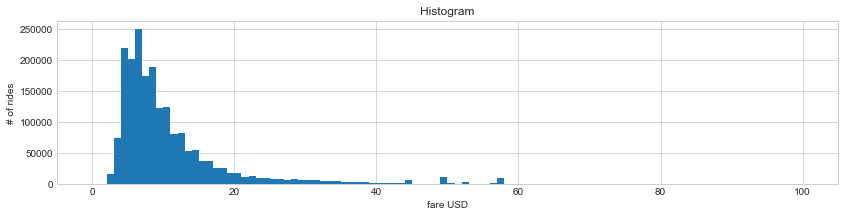

In [8]:
#histogram for fare

df_train[df_train.fare_amount<100].fare_amount.hist(bins=100, figsize=(14,3))
plt.xlabel('fare USD')
plt.ylabel('# of rides')
plt.title('Histogram')

In [9]:
#missing values

df_train.isnull().sum()
df_train = df_train.dropna(axis = 'rows', how = 'any')
print(f'The new dataset has {len(df_train)} rows')

The new dataset has 1999853 rows


In [10]:
#duplicated values
print(f'there is {df_train.duplicated().sum()} duplicated values')

there is 0 duplicated values


## Test Data

In [11]:
df_test = pd.read_csv('all/test.csv', parse_dates=['pickup_datetime'])

In [12]:
df_test.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12,-73.966046,40.789775,-73.988565,40.744427,1


In [13]:
df_test.describe()


,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974722,40.751041,-73.973657,40.751743,1.671273
std,0.042774,0.033541,0.039072,0.035435,1.278747
min,-74.252193,40.573143,-74.263242,40.568973,1.000000
25%,-73.992501,40.736125,-73.991247,40.735254,1.000000
50%,-73.982326,40.753051,-73.980015,40.754065,1.000000
75%,-73.968013,40.767113,-73.964059,40.768757,2.000000
max,-72.986532,41.709555,-72.990963,41.696683,6.000000


## Data on map

In [14]:
# minimum and maximum longitude test set

min(df_test.pickup_longitude.min(), df_test.dropoff_longitude.min()), \
max(df_test.pickup_longitude.max(), df_test.dropoff_longitude.max())

(-74.263242, -72.986532)

In [15]:
# minimum and maximum latitude test
min(df_test.pickup_latitude.min(), df_test.dropoff_latitude.min()), \
max(df_test.pickup_latitude.max(), df_test.dropoff_latitude.max())

(40.568973, 41.709555)

In [16]:
# this function will also be used with the test set below
def select_within_boundingbox(df, BB):
    return (df.pickup_longitude >= BB[0]) & (df.pickup_longitude <= BB[1]) & \
           (df.pickup_latitude >= BB[2]) & (df.pickup_latitude <= BB[3]) & \
           (df.dropoff_longitude >= BB[0]) & (df.dropoff_longitude <= BB[1]) & \
           (df.dropoff_latitude >= BB[2]) & (df.dropoff_latitude <= BB[3])
BB = (-74.5, -72.8, 40.5, 41.8)
nyc_map = plt.imread('https://aiblog.nl/download/nyc_-74.5_-72.8_40.5_41.8.png')

# load extra image to zoom in on NYC
BB_zoom = (-74.3, -73.7, 40.5, 40.9)
nyc_map_zoom = plt.imread('https://aiblog.nl/download/nyc_-74.3_-73.7_40.5_40.9.png') 

In [17]:
df_train = df_train[select_within_boundingbox(df_train, BB)]


In [18]:
# Plot on map function:
def plot_on_map(df, BB, nyc_map, s=10, alpha=0.2, color = False):
    fig, axs = plt.subplots(1, 2, figsize=(18,22))
    axs[0].scatter(df.pickup_longitude, df.pickup_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[0].set_xlim((BB[0], BB[1]))
    axs[0].set_ylim((BB[2], BB[3]))
    axs[0].set_title('Pickup locations')
    axs[0].imshow(nyc_map, zorder=0, extent=BB)

    axs[1].scatter(df.dropoff_longitude, df.dropoff_latitude, zorder=1, alpha=alpha, c='b', s=s)
    axs[1].set_xlim((BB[0], BB[1]))
    axs[1].set_ylim((BB[2], BB[3]))
    axs[1].set_title('Dropoff locations')
    axs[1].imshow(nyc_map, zorder=0, extent=BB)

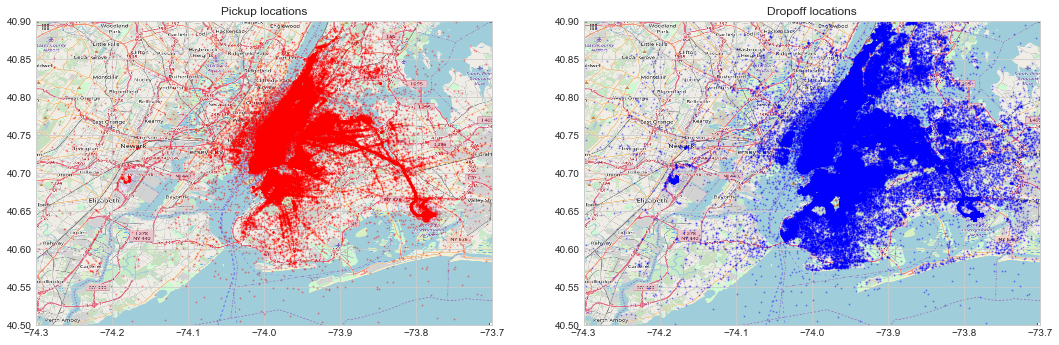

In [19]:
#Train Data
plot_on_map(df_train, BB_zoom, nyc_map_zoom, s=1, alpha=0.3)

#We can see that there is more people ordering a taxi from nyc manathan to outside manathan than the opposite

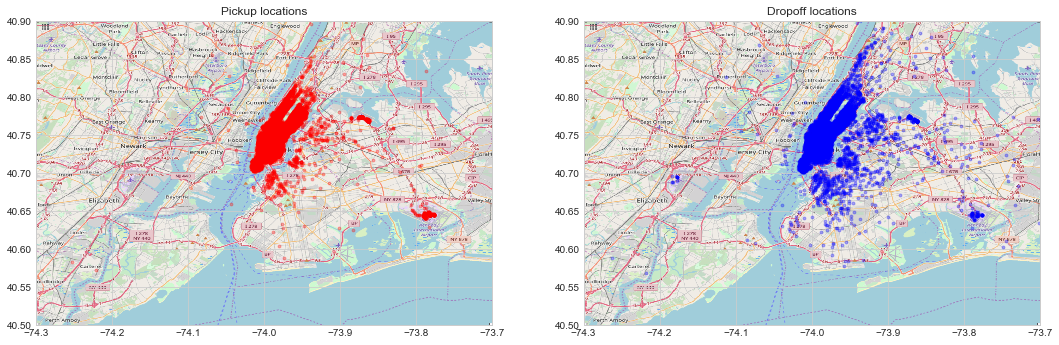

In [20]:
#test Data
plot_on_map(df_test, BB_zoom, nyc_map_zoom, s=8, alpha=0.3)


## Black and White map

In [31]:
def plot_hires(df, BB, figsize=(12, 12), ax=None, c=('w', 'w')):
    if ax == None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)

    idx = select_within_boundingbox(df, BB)
    ax.set_facecolor('black')
    ax.grid(False)
    ax.scatter(df[idx].pickup_longitude, df[idx].pickup_latitude, c=c[0], s=0.01, alpha=0.2)
    ax.scatter(df[idx].dropoff_longitude, df[idx].dropoff_latitude, c=c[1], s=0.01, alpha=0.2)
    


I have decided to prit the drop-off and pick-up location the same color. In fact they overlapse each other in many case, which is not very interesting for our case. What we can see with this techniques is that most of the rides are within Mannathan. 

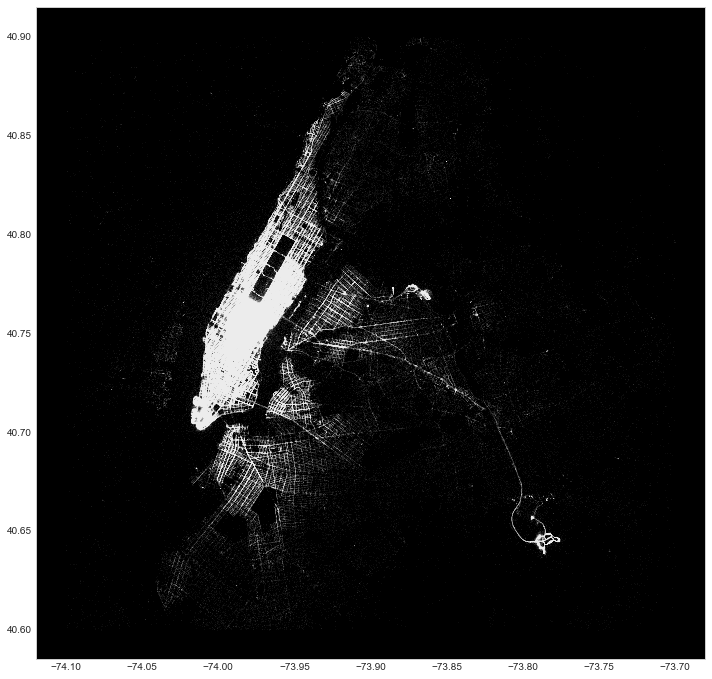

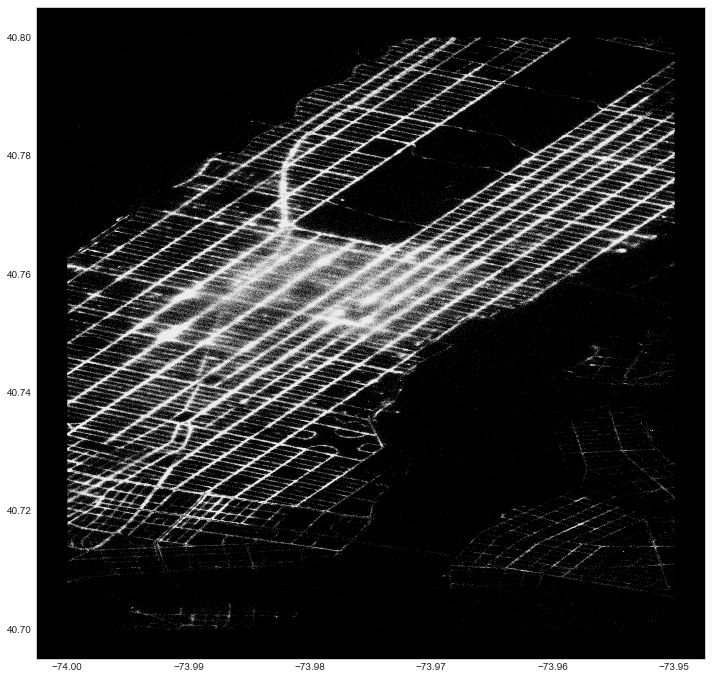

In [32]:
plot_hires(df_train, (-74.1, -73.7, 40.6, 40.9))
plot_hires(df_train, (-74, -73.95, 40.7, 40.8))
